In [1]:
# lambdarank_yahoo.py
# ---------------------------------------------------------
# Minimal LambdaRank (pairwise) with ΔNDCG@k weighting.
# Backends:
#   (A) TFDS: yahoo_ltrc/set1
#   (B) LibSVM: train.txt, vali.txt, test.txt with 'qid:'
# ---------------------------------------------------------

import argparse
import math
import os
import random
from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ---------------------------
# Utilities
# ---------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def log2_safe(x: torch.Tensor) -> torch.Tensor:
    return torch.log(x) / math.log(2.0)


def dcg_at_k(scores: np.ndarray, labels: np.ndarray, k: int) -> float:
    """Compute DCG@k given predicted scores and integer labels."""
    order = np.argsort(-scores)
    topk = order[:k]
    gains = (2.0 ** labels[topk] - 1.0)
    discounts = 1.0 / np.log2(np.arange(2, 2 + len(topk)))
    return float(np.sum(gains * discounts))


def idcg_at_k(labels: np.ndarray, k: int) -> float:
    """Ideal DCG@k from labels only."""
    order = np.argsort(-labels)
    topk = order[:k]
    gains = (2.0 ** labels[topk] - 1.0)
    discounts = 1.0 / np.log2(np.arange(2, 2 + len(topk)))
    return float(np.sum(gains * discounts))


def ndcg_at_k(scores: np.ndarray, labels: np.ndarray, k: int) -> float:
    ideal = idcg_at_k(labels, k)
    if ideal <= 0:
        return 0.0
    return dcg_at_k(scores, labels, k) / ideal


# ---------------------------
# Data loading (two backends)
# ---------------------------

def _stack_groups(groups_X, groups_y) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    X_groups, y_groups = [], []
    for qid in sorted(groups_X.keys()):
        X = np.vstack(groups_X[qid])  # (n_docs, F)
        y = np.asarray(groups_y[qid], dtype=np.int64)
        X_groups.append(X)
        y_groups.append(y)
    return X_groups, y_groups


def load_tfds_yahoo_set1() -> Tuple[List[np.ndarray], List[np.ndarray],
                                     List[np.ndarray], List[np.ndarray],
                                     int]:
    """
    Loads Yahoo LTRC 'set1' via TFDS and groups by query id.
    Returns (X_train_groups, y_train_groups, X_val_groups, y_val_groups, n_features).
    """
    try:
        import tensorflow_datasets as tfds
        import tensorflow as tf  # tfds needs TF to iterate datasets
    except Exception as e:
        raise RuntimeError(
            "TFDS backend requested, but 'tensorflow-datasets' (and TensorFlow) is not available.\n"
            "Install with: pip install tensorflow-datasets tensorflow"
        ) from e

    def _get_field(example, names):
        for n in names:
            if n in example:
                return example[n]
        raise KeyError(f"None of the expected fields {names} found in example keys: {list(example.keys())}")

    # Load splits: train/validation/test
    ds_train = tfds.load("yahoo_ltrc/set1", split="train", as_supervised=False)
    ds_valid = tfds.load("yahoo_ltrc/set1", split="validation", as_supervised=False)
    # test also available if needed
    # ds_test  = tfds.load("yahoo_ltrc/set1", split="test", as_supervised=False)

    # Accumulate by qid
    groups_X_tr: Dict[int, List[np.ndarray]] = {}
    groups_y_tr: Dict[int, List[int]] = {}
    groups_X_va: Dict[int, List[np.ndarray]] = {}
    groups_y_va: Dict[int, List[int]] = {}

    def ingest(ds, gx, gy):
        for ex in tfds.as_numpy(ds):
            # Attempt robust field names
            feat = None
            for cand in ("features", "document_features", "x", "feature_vector"):
                if cand in ex:
                    feat = ex[cand]
                    break
            if feat is None:
                # Sometimes everything is nested under "features"
                if "features" in ex and isinstance(ex["features"], dict):
                    inner = ex["features"]
                    for cand in ("features", "x", "document_features"):
                        if cand in inner:
                            feat = inner[cand]
                            break
            if feat is None:
                raise KeyError(f"Cannot locate features in example keys: {list(ex.keys())}")

            rel = None
            for cand in ("relevance", "label", "y"):
                if cand in ex:
                    rel = ex[cand]
                    break
            if rel is None:
                # maybe nested
                if "features" in ex and isinstance(ex["features"], dict) and "relevance" in ex["features"]:
                    rel = ex["features"]["relevance"]
            if rel is None:
                raise KeyError("Cannot locate relevance/label field")

            qid = None
            for cand in ("qid", "query_id", "queryid"):
                if cand in ex:
                    qid = int(ex[cand])
                    break
            if qid is None:
                # nested possibility
                if "features" in ex and isinstance(ex["features"], dict) and "qid" in ex["features"]:
                    qid = int(ex["features"]["qid"])
            if qid is None:
                raise KeyError("Cannot locate qid/query_id field")

            feat = np.asarray(feat, dtype=np.float32).ravel()
            rel = int(rel)

            gx.setdefault(qid, []).append(feat)
            gy.setdefault(qid, []).append(rel)

    ingest(ds_train, groups_X_tr, groups_y_tr)
    ingest(ds_valid, groups_X_va, groups_y_va)

    X_tr, y_tr = _stack_groups(groups_X_tr, groups_y_tr)
    X_va, y_va = _stack_groups(groups_X_va, groups_y_va)

    n_features = X_tr[0].shape[1]
    return X_tr, y_tr, X_va, y_va, n_features


def _parse_svmlight_line(line: str) -> Tuple[int, int, Dict[int, float]]:
    """
    Parses one SVMLight LTR line: '<label> qid:<qid> 1:val1 2:val2 ...'
    Returns (label, qid, {feat_idx: value, ...}), 1-based indices in file.
    """
    parts = line.strip().split()
    if not parts:
        raise ValueError("Empty line")
    label = int(float(parts[0]))
    qid = None
    feats = {}
    for tok in parts[1:]:
        if tok.startswith("qid:"):
            qid = int(tok.split(":")[1])
        else:
            k, v = tok.split(":")
            feats[int(k)] = float(v)
    if qid is None:
        raise ValueError("Missing qid in line")
    return label, qid, feats


def load_libsvm_grouped(data_dir: str) -> Tuple[List[np.ndarray], List[np.ndarray],
                                                List[np.ndarray], List[np.ndarray],
                                                int]:
    """
    Reads Yahoo LTRC (SVMLight) from data_dir containing train.txt, vali.txt, test.txt.
    Groups by qid. Feature dimension inferred from max feature index.
    """
    def read_file(path: str):
        groups_X: Dict[int, List[np.ndarray]] = {}
        groups_y: Dict[int, List[int]] = {}
        max_f = 0
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                label, qid, feats = _parse_svmlight_line(line)
                if feats:
                    max_f = max(max_f, max(feats.keys()))
                groups_y.setdefault(qid, []).append(label)
                groups_X.setdefault(qid, []).append(feats)
        return groups_X, groups_y, max_f

    train_fp = os.path.join(data_dir, "set1.train.txt")
    vali_fp = os.path.join(data_dir, "set1.valid.txt")
    if not os.path.exists(train_fp) or not os.path.exists(vali_fp):
        raise FileNotFoundError(
            f"Expected 'train.txt' and 'vali.txt' under {data_dir} (SVMLight with qid)."
        )

    gXt, gYt, mf_t = read_file(train_fp)
    gXv, gYv, mf_v = read_file(vali_fp)
    Fdim = max(mf_t, mf_v)

    def densify(gX: Dict[int, List[Dict[int, float]]], F: int) -> List[np.ndarray]:
        X_groups = []
        for qid in sorted(gX.keys()):
            rows = gX[qid]
            X = np.zeros((len(rows), F), dtype=np.float32)
            for i, d in enumerate(rows):
                for k, v in d.items():
                    # convert 1-based to 0-based
                    if 1 <= k <= F:
                        X[i, k - 1] = v
            X_groups.append(X)
        return X_groups

    X_tr = densify(gXt, Fdim)
    y_tr = [np.asarray(gYt[qid], dtype=np.int64) for qid in sorted(gYt.keys())]
    X_va = densify(gXv, Fdim)
    y_va = [np.asarray(gYv[qid], dtype=np.int64) for qid in sorted(gYv.keys())]

    return X_tr, y_tr, X_va, y_va, Fdim


# ---------------------------
# PyTorch Dataset / DataLoader
# ---------------------------

class QueryDataset(torch.utils.data.Dataset):
    def __init__(self, X_groups: List[np.ndarray], y_groups: List[np.ndarray], scaler: Optional[StandardScaler] = None):
        assert len(X_groups) == len(y_groups)
        self.X_groups = X_groups
        self.y_groups = y_groups
        self.scaler = scaler

    def __len__(self):
        return len(self.X_groups)

    def __getitem__(self, idx):
        X = self.X_groups[idx]
        y = self.y_groups[idx]
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return torch.from_numpy(X).float(), torch.from_numpy(y).long()


def collate_query_batch(batch):
    # batch is a list of (X, y) for several queries; keep ragged
    Xs, ys = zip(*batch)  # tuple of tensors with shapes [n_qi, F], [n_qi]
    return Xs, ys


# ---------------------------
# Model
# ---------------------------

class MLPScorer(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int] = [256, 128], dropout: float = 0.0):
        super().__init__()
        layers: List[nn.Module] = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU(inplace=True)]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # returns shape (N, 1)
        return self.net(x)


# ---------------------------
# LambdaRank Loss (pairwise with ΔNDCG@k)
# ---------------------------

def lambdarank_pairwise_loss(scores: torch.Tensor,
                             labels: torch.Tensor,
                             k: Optional[int] = 10,
                             sigma: float = 1.0) -> torch.Tensor:
    """
    scores: (n_docs,)
    labels: (n_docs,) int labels in {0,...}
    Returns scalar loss for one query.
    """
    n = scores.shape[0]
    if n <= 1:
        return torch.zeros((), device=scores.device)

    # If all labels identical => no learning signal
    if (labels == labels[0]).all():
        return torch.zeros((), device=scores.device)

    # Compute positions under current scores (descending)
    order = torch.argsort(scores, descending=True)
    # pos[i] = rank position (0-based) of doc i
    pos = torch.empty_like(order)
    pos[order] = torch.arange(n, device=scores.device)

    # Gains and discounts (for @k truncation)
    gains = torch.pow(2.0, labels.float()) - 1.0
    disc = 1.0 / log2_safe(pos.float() + 2.0)  # 1/log2(rank+2) since pos is 0-based
    if k is not None:
        disc = torch.where(pos < k, disc, torch.zeros_like(disc))

    # Ideal DCG@k (based on labels only)
    with torch.no_grad():
        sorted_labels, _ = torch.sort(labels, descending=True)
        topk = sorted_labels[:k] if k is not None else sorted_labels
        ideal_disc = 1.0 / torch.log2(torch.arange(2, 2 + topk.numel(), device=scores.device).float())
        idcg = torch.sum((torch.pow(2.0, topk.float()) - 1.0) * ideal_disc)
    if idcg <= 0:
        return torch.zeros((), device=scores.device)

    # Pairwise masks and differences
    Sij = scores.unsqueeze(1) - scores.unsqueeze(0)               # (n,n)
    y_i = labels.unsqueeze(1)
    y_j = labels.unsqueeze(0)
    pair_mask = (y_i > y_j)                                       # only i more relevant than j

    # ΔNDCG weights (vectorized):
    # |(gain_i - gain_j) * (disc_i - disc_j)| / IDCG
    gain_i = gains.unsqueeze(1)
    gain_j = gains.unsqueeze(0)
    disc_i = disc.unsqueeze(1)
    disc_j = disc.unsqueeze(0)
    delta_ndcg = torch.abs((gain_i - gain_j) * (disc_i - disc_j)) / idcg.clamp_min(1e-12)

    # Logistic pairwise loss with scaling sigma (equivalently RankNet)
    # log(1 + exp(-sigma * (s_i - s_j)))
    loss_mat = F.softplus(-sigma * Sij) * delta_ndcg

    # Apply mask & normalize by number of valid pairs
    num_pairs = pair_mask.sum()
    if num_pairs == 0:
        return torch.zeros((), device=scores.device)
    loss = (loss_mat * pair_mask).sum() / num_pairs.float()
    return loss


# ---------------------------
# Training / Evaluation
# ---------------------------

@torch.no_grad()
def evaluate_ndcg(model: nn.Module,
                  dataset: QueryDataset,
                  device: torch.device,
                  k: int = 10) -> float:
    model.eval()
    ndcgs: List[float] = []
    for i in range(len(dataset)):
        X, y = dataset[i]
        X = X.to(device)
        scores = model(X).squeeze(-1).cpu().numpy()
        lbls = y.numpy()
        ndcgs.append(ndcg_at_k(scores, lbls, k))
    return float(np.mean(ndcgs)) if ndcgs else 0.0


def train(model: nn.Module,
          train_ds: QueryDataset,
          val_ds: QueryDataset,
          device: torch.device,
          epochs: int = 10,
          lr: float = 1e-3,
          weight_decay: float = 0.0,
          batch_queries: int = 32,
          k: int = 10,
          sigma: float = 1.0,
          early_stop: int = 5):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_queries,
                                         shuffle=True, collate_fn=collate_query_batch, num_workers=0)

    best_val = -1.0
    best_state = None
    patience = 0

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        batches = 0

        for Xs, ys in loader:
            opt.zero_grad()
            batch_loss = 0.0
            for X, y in zip(Xs, ys):
                X = X.to(device)
                y = y.to(device)
                s = model(X).squeeze(-1)               # (n_docs,)
                loss_q = lambdarank_pairwise_loss(s, y, k=k, sigma=sigma)
                batch_loss = batch_loss + loss_q
            if len(Xs) > 0:
                batch_loss = batch_loss / len(Xs)
            batch_loss.backward()
            opt.step()
            total_loss += batch_loss.item()
            batches += 1

        train_loss = total_loss / max(1, batches)
        val_ndcg = evaluate_ndcg(model, val_ds, device, k=k)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.5f}  val_NDCG@{k}={val_ndcg:.5f}")

        if val_ndcg > best_val + 1e-6:
            best_val = val_ndcg
            best_state = {k_: v_.cpu().clone() for k_, v_ in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                print(f"Early stopping (no improvement for {early_stop} epochs).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val


# ---------------------------
# Main
# ---------------------------

def main():
    parser = argparse.ArgumentParser(description="LambdaRank (NN) on Yahoo! LTRC")
    parser.add_argument("--backend", type=str, default="tfds", choices=["tfds", "libsvm"],
                        help="Data backend: 'tfds' for tensorflow-datasets yahoo_ltrc/set1, "
                             "'libsvm' for files train.txt/vali.txt/test.txt in --data_dir.")
    parser.add_argument("--data_dir", type=str, default=None,
                        help="Folder containing train.txt/vali.txt/test.txt (SVMLight with qid). Used if --backend libsvm.")
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--epochs", type=int, default=10)
    parser.add_argument("--batch_queries", type=int, default=32, help="Number of queries per batch.")
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--weight_decay", type=float, default=0.0)
    parser.add_argument("--hidden", type=int, nargs="+", default=[256, 128])
    parser.add_argument("--dropout", type=float, default=0.0)
    parser.add_argument("--k", type=int, default=10, help="ΔNDCG and evaluation cutoff (k in NDCG@k).")
    parser.add_argument("--sigma", type=float, default=1.0, help="Scale for pairwise logistic loss.")
    parser.add_argument("--standardize", action="store_true", help="Standardize features per-dimension (recommended for LibSVM).")
    args = parser.parse_args()

    set_seed(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data (train/valid). You can similarly load test if needed.
    if args.backend == "tfds":
        X_tr, y_tr, X_va, y_va, F = load_tfds_yahoo_set1()
    else:
        if args.data_dir is None:
            raise ValueError("--data_dir is required when backend='libsvm'")
        X_tr, y_tr, X_va, y_va, F = load_libsvm_grouped(args.data_dir)

    # Optional standardization (fit on train, apply to train/val)
    scaler = None
    if args.standardize:
        scaler = StandardScaler(with_mean=True, with_std=True)
        # fit on concatenated train docs
        X_concat = np.vstack(X_tr)
        scaler.fit(X_concat)

    train_ds = QueryDataset(X_tr, y_tr, scaler=scaler)
    val_ds   = QueryDataset(X_va, y_va, scaler=scaler)

    model = MLPScorer(in_dim=F, hidden=args.hidden, dropout=args.dropout)

    model, best_val = train(model, train_ds, val_ds, device,
                            epochs=args.epochs, lr=args.lr, weight_decay=args.weight_decay,
                            batch_queries=args.batch_queries, k=args.k, sigma=args.sigma,
                            early_stop=5)

    # Final validation report
    val_ndcg = evaluate_ndcg(model, val_ds, device, k=args.k)
    print(f"Best Val NDCG@{args.k}: {best_val:.5f} | Final Val NDCG@{args.k}: {val_ndcg:.5f}")

    # (Optional) If you also have a test split, evaluate similarly.




/Users/mzheng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.argv = [
    "lambdarank_yahoo.py",
    "--backend", "libsvm",
    "--data_dir", "Learning to Rank Challenge/ltrc_yahoo/",
    "--standardize",
    "--epochs", "10"
]


In [32]:

parser = argparse.ArgumentParser(description="LambdaRank (NN) on Yahoo! LTRC")
parser.add_argument("--backend", type=str, default="libsvm", choices=["tfds", "libsvm"],
                    help="Data backend: 'tfds' for tensorflow-datasets yahoo_ltrc/set1, "
                            "'libsvm' for files train.txt/vali.txt/test.txt in --data_dir.")
parser.add_argument("--data_dir", type=str, default=None,
                    help="Folder containing train.txt/vali.txt/test.txt (SVMLight with qid). Used if --backend libsvm.")
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--epochs", type=int, default=30)
parser.add_argument("--batch_queries", type=int, default=256, help="Number of queries per batch.")
parser.add_argument("--lr", type=float, default=3e-3)
parser.add_argument("--weight_decay", type=float, default=0.0)
parser.add_argument("--hidden", type=int, nargs="+", default=[256, 128])
parser.add_argument("--dropout", type=float, default=0.0)
parser.add_argument("--k", type=int, default=10, help="ΔNDCG and evaluation cutoff (k in NDCG@k).")
parser.add_argument("--sigma", type=float, default=1.0, help="Scale for pairwise logistic loss.")
parser.add_argument("--standardize", action="store_true", help="Standardize features per-dimension (recommended for LibSVM).")

args = parser.parse_args()

args.data_dir = "Learning to Rank Challenge/ltrc_yahoo/"

set_seed(args.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data (train/valid). You can similarly load test if needed.
if args.backend == "tfds":
    X_tr, y_tr, X_va, y_va, n_features = load_tfds_yahoo_set1()
else:
    if args.data_dir is None:
        raise ValueError("--data_dir is required when backend='libsvm'")
    X_tr, y_tr, X_va, y_va, n_features = load_libsvm_grouped(args.data_dir)

# Optional standardization (fit on train, apply to train/val)
scaler = None
if args.standardize:
    scaler = StandardScaler(with_mean=True, with_std=True)
    # fit on concatenated train docs
    X_concat = np.vstack(X_tr)
    scaler.fit(X_concat)

train_ds = QueryDataset(X_tr, y_tr, scaler=scaler)
val_ds   = QueryDataset(X_va, y_va, scaler=scaler)

model = MLPScorer(in_dim=n_features, hidden=args.hidden, dropout=args.dropout)

model, best_val = train(model, train_ds, val_ds, device,
                        epochs=args.epochs, lr=args.lr, weight_decay=args.weight_decay,
                        batch_queries=args.batch_queries, k=args.k, sigma=args.sigma,
                        early_stop=5)

# Final validation report
val_ndcg = evaluate_ndcg(model, val_ds, device, k=args.k)
print(f"Best Val NDCG@{args.k}: {best_val:.5f} | Final Val NDCG@{args.k}: {val_ndcg:.5f}")

# (Optional) If you also have a test split, evaluate similarly.


Using device: cpu
[Epoch 01] train_loss=0.03218  val_NDCG@10=0.70959
[Epoch 02] train_loss=0.02978  val_NDCG@10=0.71423
[Epoch 03] train_loss=0.02873  val_NDCG@10=0.71661
[Epoch 04] train_loss=0.02803  val_NDCG@10=0.71785
[Epoch 05] train_loss=0.02734  val_NDCG@10=0.71903
[Epoch 06] train_loss=0.02676  val_NDCG@10=0.71871
[Epoch 07] train_loss=0.02588  val_NDCG@10=0.71506
[Epoch 08] train_loss=0.02513  val_NDCG@10=0.71706
[Epoch 09] train_loss=0.02435  val_NDCG@10=0.71322
[Epoch 10] train_loss=0.02354  val_NDCG@10=0.71596
Early stopping (no improvement for 5 epochs).
Best Val NDCG@10: 0.71903 | Final Val NDCG@10: 0.71903


In [8]:
save_path = "saved_lambdarank_model.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "scaler": scaler,             # can be None
    "n_features": n_features,
    "args": vars(args)            # optional: saves hyperparameters
}, save_path)

print(f"Model saved to {save_path}")

Model saved to saved_lambdarank_model.pt


In [9]:
# -----------------------------
# Reload model + scaler
# -----------------------------
checkpoint = torch.load("saved_lambdarank_model.pt", map_location=device)

# Recreate model
loaded_model = MLPScorer(
    in_dim=checkpoint["n_features"],
    hidden=checkpoint["args"]["hidden"],
    dropout=checkpoint["args"]["dropout"]
)

loaded_model.load_state_dict(checkpoint["model_state_dict"])
loaded_model.to(device)
loaded_model.eval()

loaded_scaler = checkpoint["scaler"]   # may be None

print("Model + scaler successfully reloaded.")


Model + scaler successfully reloaded.


/var/folders/b5/znfvxcd946qb0gfsq9j1td2c0000gn/T/ipykernel_36232/4110000800.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("saved_lambdarank_mod

In [ ]:
# ==========================================================
#  🧩 Predict on test data and summarize into DataFrame
# ==========================================================

def predict_and_summarize(model, data_dir, device, Fdim, scaler=None):
    """Predict scores for each (qid, doc) pair in set1.test.txt and summarize into a DataFrame."""
    test_fp = os.path.join(data_dir, "set1.test.txt")
    if not os.path.exists(test_fp):
        raise FileNotFoundError(f"Missing test file: {test_fp}")
    print(f"Predicting on {test_fp}")

    # Reuse parser from training
    def _parse_svmlight_line(line: str):
        parts = line.strip().split()
        label = int(float(parts[0]))
        qid = None
        feats = {}
        for tok in parts[1:]:
            if tok.startswith("qid:"):
                qid = int(tok.split(":")[1])
            else:
                k, v = tok.split(":")
                feats[int(k)] = float(v)
        return label, qid, feats

    # ---- Read & densify by qid ----
    groups_X, groups_y, max_f = {}, {}, 0
    with open(test_fp, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            label, qid, feats = _parse_svmlight_line(line)
            groups_y.setdefault(qid, []).append(label)
            groups_X.setdefault(qid, []).append(feats)
            max_f = max(max_f, max(feats.keys()))

    X_groups, y_groups, qids = [], [], sorted(groups_X.keys())
    for qid in qids:
        rows = groups_X[qid]
        X = np.zeros((len(rows), Fdim), dtype=np.float32)
        for i, d in enumerate(rows):
            for k, v in d.items():
                if 1 <= k <= Fdim:
                    X[i, k - 1] = v
        if scaler is not None:
            X = scaler.transform(X)
        X_groups.append(X)
        y_groups.append(np.asarray(groups_y[qid], dtype=np.int64))

    # ---- Predict ----
    model.eval()
    rows = []
    doc_id = 0
    with torch.no_grad():
        for qid, X, y in zip(qids, X_groups, y_groups):
            X = torch.from_numpy(X).float().to(device)
            scores = model(X).squeeze(-1).cpu().numpy()
            for i in range(len(y)):
                rows.append({
                    "qid": qid,
                    "doc_id": doc_id,
                    "label": int(y[i]),
                    "pred_score": float(scores[i])
                })
                doc_id += 1

    df = pd.DataFrame(rows)
    print(f"✅ Prediction summary: {df.shape[0]} rows, {df['qid'].nunique()} unique queries.")
    return df

# ----------------------------------------------------------
# Run prediction and summarize
# ----------------------------------------------------------
df_summary = predict_and_summarize(loaded_model, args.data_dir, device, n_features, scaler)
df_summary["pred_score"] = 1 / (1 + np.exp(-df_summary["pred_score"]))
print(df_summary.head())


df_summary.to_csv("yahoo_test_predictions.csv", index=False)
print("Saved: yahoo_test_predictions.csv")


Predicting on Learning to Rank Challenge/ltrc_yahoo/set1.test.txt
✅ Prediction summary: 165660 rows, 6983 unique queries.
     qid  doc_id  label  pred_score
0  22939       0      0    0.499997
1  22939       1      1    0.442625
2  22939       2      1    0.774426
3  22939       3      0    0.618009
4  22939       4      0    0.661404
Saved: yahoo_test_predictions.csv


In [38]:
def write_test_subset(data_dir, k_queries=1000, 
                      input_name="set1.test.txt",
                      output_name="set1.test.small.txt"):
    """
    Create a smaller SVMLight test file containing only the first `k_queries`.
    """

    input_fp = os.path.join(data_dir, input_name)
    output_fp = os.path.join(data_dir, output_name)

    if not os.path.exists(input_fp):
        raise FileNotFoundError(f"Original test file not found: {input_fp}")

    seen_qids = set()
    out_lines = []

    with open(input_fp, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue

            parts = line.split()
            qid_tok = next((tok for tok in parts if tok.startswith("qid:")), None)
            if qid_tok is None:
                continue

            qid = int(qid_tok.split(":")[1])

            # Stop once we have enough qids
            if qid not in seen_qids:
                if len(seen_qids) >= k_queries:
                    break
                seen_qids.add(qid)

            out_lines.append(line)

    with open(output_fp, "w", encoding="utf-8") as fout:
        fout.writelines(out_lines)

    print(f"✔ Created subset with {len(seen_qids)} queries")
    print(f"📄 Saved to: {output_fp}")
    return output_fp

def predict_and_summarize(model, test_fp, device, Fdim, scaler=None):
    """
    Predict scores for each (qid, doc) pair in a SVMLight-format test file.
    Returns a DataFrame.
    """
    if not os.path.exists(test_fp):
        raise FileNotFoundError(f"Missing test file: {test_fp}")
    print(f"Predicting on {test_fp}")

    def _parse_svmlight_line(line):
        parts = line.strip().split()
        label = int(float(parts[0]))
        qid = None
        feats = {}
        for tok in parts[1:]:
            if tok.startswith("qid:"):
                qid = int(tok.split(":")[1])
            else:
                k, v = tok.split(":")
                feats[int(k)] = float(v)
        return label, qid, feats

    # --------- Load file grouped by qid ---------
    groups_X, groups_y = {}, {}
    with open(test_fp, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip(): 
                continue
            label, qid, feats = _parse_svmlight_line(line)
            groups_X.setdefault(qid, []).append(feats)
            groups_y.setdefault(qid, []).append(label)

    # --------- Densify features & predict ---------
    rows = []
    doc_id = 0
    model.eval()

    for qid in sorted(groups_X.keys()):
        docs = groups_X[qid]

        X = np.zeros((len(docs), Fdim), dtype=np.float32)
        for i, d in enumerate(docs):
            for k, v in d.items():
                if 1 <= k <= Fdim:
                    X[i, k-1] = v

        if scaler is not None:
            X = scaler.transform(X)

        with torch.no_grad():
            scores = model(torch.from_numpy(X).float().to(device)).squeeze(-1).cpu().numpy()

        labels = groups_y[qid]
        for lbl, s in zip(labels, scores):
            rows.append({
                "qid": qid,
                "doc_id": doc_id,
                "label": int(lbl),
                "pred_score": float(s)
            })
            doc_id += 1

    df = pd.DataFrame(rows)
    print(f"✅ Summary: {len(df)} rows, {df['qid'].nunique()} unique queries.")
    return df
# ---------------------------------------
# Create subset of test data
# ---------------------------------------
subset_fp = write_test_subset(args.data_dir, k_queries=1000)

# ---------------------------------------
# Run prediction on the subset
# ---------------------------------------
df_summary = predict_and_summarize(
    loaded_model,
    test_fp=subset_fp,
    device=device,
    Fdim=n_features,
    scaler=scaler
)

df_summary["pred_score"] = 1 / (1 + np.exp(-df_summary["pred_score"]))
print(df_summary.head())

df_summary.to_csv(os.path.join(args.data_dir, "subset_predictions.csv"), index=False)
print("Saved: subset_predictions.csv")


✔ Created subset with 1000 queries
📄 Saved to: Learning to Rank Challenge/ltrc_yahoo/set1.test.small.txt
Predicting on Learning to Rank Challenge/ltrc_yahoo/set1.test.small.txt
✅ Summary: 37380 rows, 1000 unique queries.
     qid  doc_id  label  pred_score
0  22939       0      0    0.499997
1  22939       1      1    0.442625
2  22939       2      1    0.774426
3  22939       3      0    0.618009
4  22939       4      0    0.661404
Saved: subset_predictions.csv


Total queries (qid): 6983
Total documents: 165660
Average docs per query: 23.72

Docs-per-query distribution:
count    6983.000000
mean       23.723328
std        18.208056
min         1.000000
25%         9.000000
50%        19.000000
75%        34.000000
90%        49.000000
95%        59.000000
max       129.000000
dtype: float64


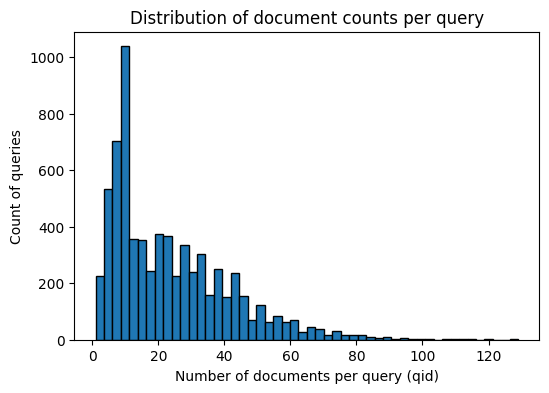

In [6]:
# ------------------------------------------------------------
# Basic summary of qids and document distribution
# ------------------------------------------------------------
n_qid = df_summary["qid"].nunique()
docs_per_qid = df_summary.groupby("qid").size()

print(f"Total queries (qid): {n_qid}")
print(f"Total documents: {len(df_summary)}")
print(f"Average docs per query: {docs_per_qid.mean():.2f}")
print("\nDocs-per-query distribution:")
print(docs_per_qid.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

# Optional: visualize histogram (if using Jupyter)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(docs_per_qid, bins=50, edgecolor='black')
plt.xlabel("Number of documents per query (qid)")
plt.ylabel("Count of queries")
plt.title("Distribution of document counts per query")
plt.show()


In [39]:

query_dict = (
    df_summary.groupby("qid")[["doc_id", "label", "pred_score"]]
      .apply(lambda g: list(zip(g["doc_id"], g["label"], g["pred_score"])))
      .to_dict()
)

def split_query_dict(query_dict, min_docs=5, test_ratio=0.5, random_state=42):
    """
    Split a query-level prediction score dictionary into disjoint calibration and test sets.

    Parameters
    ----------
    query_dict : dict
        Mapping
            qid -> [(doc_id, label, pred_score), ...]
        where each entry corresponds to all documents associated with a single query.

    min_docs : int, optional (default=5)
        Minimum number of documents required for a query to be eligible for splitting.
        Queries with fewer documents are excluded to ensure stable FDR estimation.

    test_ratio : float, optional (default=0.5)
        Fraction of eligible qids allocated to the test set. The remaining qids are used
        for calibration.

    random_state : int, optional (default=42)
        Random seed used to reproducibly shuffle and split the qids.

    Returns
    -------
    calib_dict : dict
        Subset of `query_dict` containing calibration queries only.

    test_dict : dict
        Subset of `query_dict` containing test queries only. Disjoint from `calib_dict`.

    Notes
    -----
    This function performs a *query-level* split, ensuring that all documents belonging
    to a given query are kept together. It mirrors the standard conformal prediction
    setup where calibration and test sets must not mix information across queries.
    """
    # 1️⃣ Filter qids with sufficient documents
    valid_qids = [qid for qid, docs in query_dict.items() if len(docs) > min_docs]

    # 2️⃣ Split qids
    qid_calib, qid_test = train_test_split(
        valid_qids, 
        test_size=test_ratio, 
        random_state=random_state
    )

    # 3️⃣ Build new dicts
    calib_dict = {qid: query_dict[qid] for qid in qid_calib}
    test_dict  = {qid: query_dict[qid] for qid in qid_test}

    return calib_dict, test_dict
calib_dict_full, test_dict_full = split_query_dict(query_dict, min_docs=5, test_ratio=0.5, random_state=42)

first_qid = next(iter(calib_dict_full))
print(f"Example (qid={first_qid}):")
for row in calib_dict_full[first_qid]:
    print("doc_id=%d, label=%d, score=%.3f" % row)


Example (qid=23895):
doc_id=35421, label=0, score=0.342
doc_id=35422, label=1, score=0.314
doc_id=35423, label=0, score=0.504
doc_id=35424, label=0, score=0.168
doc_id=35425, label=0, score=0.378
doc_id=35426, label=1, score=0.449
doc_id=35427, label=0, score=0.439
doc_id=35428, label=2, score=0.600
doc_id=35429, label=0, score=0.520
doc_id=35430, label=0, score=0.312
doc_id=35431, label=0, score=0.517
doc_id=35432, label=0, score=0.270
doc_id=35433, label=0, score=0.386
doc_id=35434, label=0, score=0.412
doc_id=35435, label=0, score=0.457
doc_id=35436, label=1, score=0.322
doc_id=35437, label=0, score=0.198
doc_id=35438, label=1, score=0.305
doc_id=35439, label=1, score=0.398
doc_id=35440, label=0, score=0.294
doc_id=35441, label=2, score=0.456
doc_id=35442, label=2, score=0.340
doc_id=35443, label=0, score=0.414
doc_id=35444, label=2, score=0.451
doc_id=35445, label=0, score=0.413
doc_id=35446, label=0, score=0.417
doc_id=35447, label=0, score=0.546
doc_id=35448, label=2, score=0.475

In [40]:

def compute_fdp(data_dict, lambda_value, label_threshold=3):
    """
    Compute FDP per qid given a single lambda threshold.

    Args:
        data_dict: dict {qid: [(doc_id, label, pred_score), ...]}
        lambda_value: float, threshold on pred_score
        label_threshold: int, label >= threshold → true discovery

    Returns:
        fdp_dict: {qid: fdp_value}
        summary: dict with mean FDP, mean selected, mean true discoveries
    """
    fdp_dict = {}
    n_selected_list = []
    n_true_list = []

    for qid, docs in data_dict.items():
        labels = np.array([d[1] for d in docs])
        scores = np.array([d[2] for d in docs])

        selected_mask = scores >= lambda_value
        num_selected = selected_mask.sum()
        num_true = np.logical_and(selected_mask, labels >= label_threshold).sum()
        num_false = num_selected - num_true
        fdp = num_false / num_selected if num_selected > 0 else 0.0

        fdp_dict[qid] = fdp
        n_selected_list.append(num_selected)
        n_true_list.append(num_true)

    summary = {
        "lambda": lambda_value,
        'per_sample_fdp': list(fdp_dict.values()), 
        "mean_fdp": float(np.mean(list(fdp_dict.values()))),
        'num_selected':n_selected_list,
        "mean_selected": float(np.mean(n_selected_list)),
        "mean_true": float(np.mean(n_true_list)),
    }
    return fdp_dict, summary

alpha = 0.3; delta = 0.1
lambda_step_size = 0.001
high_quality_threshold = 3 # label >= high_quality_threshold → high quality

lambda_value = 0.90  # example threshold
fdp_per_qid, summary = compute_fdp(calib_dict_full, lambda_value,label_threshold=high_quality_threshold)

print(f"λ = {summary['lambda']:.3f}")
print(f"Mean FDP: {summary['mean_fdp']:.4f}")




λ = 0.900
Mean FDP: 0.4268


In [21]:
def aggregate_fdp_test(fdp_vec, delta, alpha):
    """
    Tests: mean(FDP) + sqrt(log(1/delta)/(2n)) < alpha
    Returns a dict with components and decision.
    """
    n = len(fdp_vec)
    mean_fdp = float(fdp_vec.mean()) if n > 0 else 0.0
    penalty = float(np.sqrt(np.log(1.0 / delta) / (2.0 * max(n, 1))))
    lhs = mean_fdp + penalty
    return {
        "n": n,
        "mean_fdp": mean_fdp,
        "penalty": penalty,
        "lhs": lhs,
        "alpha": float(alpha),
        "passes": lhs < alpha
    }

def run_fdr_test(dict_full, lambda_value, delta=0.1, alpha=0.1, label_threshold=3):
    fdp_per_qid, summary = compute_fdp(dict_full, lambda_value,label_threshold=label_threshold)
    fdp_vec = np.array(list(fdp_per_qid.values()))
    out = aggregate_fdp_test(fdp_vec, delta=delta, alpha=alpha)
    return out
  
def find_lambda_hat(calib_dict_full, delta=0.2, alpha=0.3, label_threshold=3, step=0.001):
    """
    Finds the largest lambda_hat in [0.99, 0.98, ..., 0.01] that satisfies:
        mean_FDP + sqrt(log(1/delta)/(2n)) < alpha

    Args:
        calib_dict_full: dict {qid: [(doc_id, label, pred_score), ...]}
        delta, alpha: FDR control parameters
        label_threshold: int, label >= threshold means "true discovery"
        step: step size for lambda grid (default 0.01)
    """
    lambda_grid = np.arange(0.990, 0.0, -step)
    lambda_hat = None

    for lam in lambda_grid:
        res = run_fdr_test(calib_dict_full, lambda_value=lam, delta=delta, alpha=alpha, label_threshold=label_threshold)
        if res["passes"]:
            lambda_hat = lam  # still satisfies inequality
            fdr_hat = res['mean_fdp']
        else:
            break  # first failure — previous λ was the largest feasible one
        
    return lambda_hat,fdr_hat

def plot_fdp_hist(summary, alpha=0.3):
    """
    summary: dict returned by run_fdr_test() extended to include 'per_sample_fdp'
             or directly a dict containing 'per_sample_fdp': np.array of FDPs
    alpha: target FDR level
    """
    fdp_vals = np.array(summary["per_sample_fdp"])
    frac_below = np.mean(fdp_vals <= alpha)

    plt.figure(figsize=(6,4))
    plt.hist(fdp_vals, bins=30, color="steelblue", alpha=0.7, edgecolor="black")
    plt.axvline(alpha, color="red", linestyle="--", linewidth=2, label=f"α = {alpha}")
    plt.xlabel("Per-query FDP")
    plt.ylabel("Count")
    plt.title(f"Distribution of per-query FDPs (fraction ≤ α = {frac_below:.2f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # print(f"Fraction of queries with FDP ≤ α: {frac_below:.3f}")
    return frac_below


In [41]:


lambda_hat, fdr_hat= find_lambda_hat(calib_dict_full, delta=alpha, alpha=delta, step=lambda_step_size,label_threshold=high_quality_threshold)
print(f"λ̂ = {lambda_hat}")
fdp_per_qid, summary = compute_fdp(test_dict_full, lambda_hat)
fdp_vals = np.array(summary["per_sample_fdp"])
frac_below = np.mean(fdp_vals <= alpha)
print(f"Mean Test FDP: {summary['mean_fdp']:.4f}")
# print(f"fraction of FDP <= alpha: {frac_below:.4f}")
# frac_below = plot_fdp_hist(summary, alpha=alpha)


λ̂ = 0.989
Mean Test FDP: 0.0747


📊 True set size summary over 494 queries:
  mean_true_size: 4.13
  median_true_size: 3.00
  std_true_size: 4.83
  min_true_size: 0.00
  max_true_size: 26.00


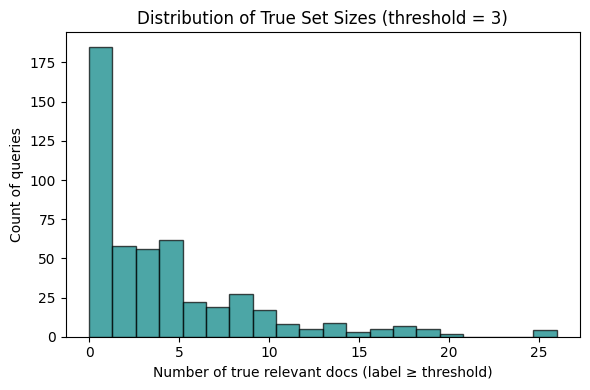

In [42]:

def compute_true_set_size(test_dict_full, label_threshold=3, plot=True):
    """
    Compute the number of truly relevant documents per query:
        |S_i^{true}| = #{doc: label >= label_threshold}.
    Optionally plot the distribution.
    """
    true_sizes = []
    for qid, docs in test_dict_full.items():
        labels = [label for _, label, _ in docs]
        true_size = sum(l >= label_threshold for l in labels)
        true_sizes.append(true_size)

    true_sizes = np.array(true_sizes)
    summary = {
        "mean_true_size": np.mean(true_sizes),
        "median_true_size": np.median(true_sizes),
        "std_true_size": np.std(true_sizes),
        "min_true_size": np.min(true_sizes),
        "max_true_size": np.max(true_sizes),
        "n_queries": len(true_sizes)
    }

    print(f"📊 True set size summary over {summary['n_queries']} queries:")
    for k, v in summary.items():
        if k != "n_queries":
            print(f"  {k}: {v:.2f}")

    if plot:
        plt.figure(figsize=(6,4))
        plt.hist(true_sizes, bins=20, color="teal", edgecolor="black", alpha=0.7)
        plt.xlabel("Number of true relevant docs (label ≥ threshold)")
        plt.ylabel("Count of queries")
        plt.title(f"Distribution of True Set Sizes (threshold = {label_threshold})")
        plt.tight_layout()
        plt.show()

    return true_sizes, summary
true_sizes, summary_true = compute_true_set_size(test_dict_full, label_threshold=3)

In [43]:

n_exp = 100
alpha = 0.3
delta = 0.1
lambda_step_size = 0.001
high_quality_threshold = 3

mean_fdr_list = []
lambda_list = []
success_flags = []
mean_size_list=[]
mean_true_size_list=[]

for exp in range(n_exp):
    # Split data into calibration and test
    calib_dict_full, test_dict_full = split_query_dict(query_dict, min_docs=5, test_ratio=0.5, random_state=42+exp)


    # Find λ̂ and calibration FDR
    lambda_hat, fdr_hat = find_lambda_hat(calib_dict_full, delta=delta, alpha=alpha, step=lambda_step_size)
    lambda_list.append(lambda_hat)

    # Evaluate empirical mean FDP on test set
    fdp_per_qid, summary = compute_fdp(test_dict_full, lambda_hat)
    true_sizes, summary_true = compute_true_set_size(test_dict_full, label_threshold=high_quality_threshold, plot=False)

    mean_fdr = summary["mean_fdp"]
    mean_size = summary['mean_selected']
    mean_size_list.append(mean_size)
    mean_true_size_list.append(summary_true['mean_true_size'])
    mean_fdr_list.append(mean_fdr)
    success_flags.append(mean_fdr <= alpha)

    print(f"[Exp {exp+1:03d}/{n_exp}] λ̂={lambda_hat:.3f} | mean FDR={mean_fdr:.3f} | pass={mean_fdr <= alpha}")


📊 True set size summary over 494 queries:
  mean_true_size: 4.13
  median_true_size: 3.00
  std_true_size: 4.83
  min_true_size: 0.00
  max_true_size: 26.00
[Exp 001/100] λ̂=0.951 | mean FDR=0.266 | pass=True
📊 True set size summary over 494 queries:
  mean_true_size: 4.24
  median_true_size: 3.00
  std_true_size: 4.76
  min_true_size: 0.00
  max_true_size: 26.00
[Exp 002/100] λ̂=0.953 | mean FDR=0.253 | pass=True
📊 True set size summary over 494 queries:
  mean_true_size: 3.92
  median_true_size: 2.00
  std_true_size: 4.79
  min_true_size: 0.00
  max_true_size: 26.00
[Exp 003/100] λ̂=0.956 | mean FDR=0.224 | pass=True
📊 True set size summary over 494 queries:
  mean_true_size: 4.11
  median_true_size: 3.00
  std_true_size: 4.76
  min_true_size: 0.00
  max_true_size: 26.00
[Exp 004/100] λ̂=0.949 | mean FDR=0.283 | pass=True
📊 True set size summary over 494 queries:
  mean_true_size: 4.03
  median_true_size: 3.00
  std_true_size: 4.43
  min_true_size: 0.00
  max_true_size: 25.00
[Exp 00


================== Conformal FDR Summary ==================
α (target FDR level):         0.300
δ (tolerence probability):    0.100

Target guarantee:             P(FDR ≤ α) ≥ 1 − δ = 0.900
Empirical estimate:           P̂(FDR ≤ α) = 0.980

Mean FDR with std across runs:         0.253  ±  0.023
Mean set size with std:                2.41 ± 0.24



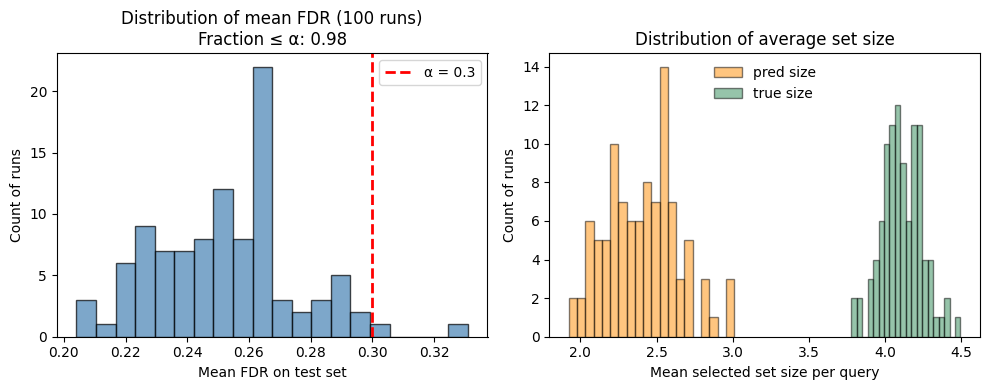

In [44]:
# -------------------------------------------------------------
# Aggregate and report results
# -------------------------------------------------------------
p_hat = np.mean(success_flags)                     # empirical P(FDR ≤ α)
mean_fdr_mean = np.mean(mean_fdr_list)             # avg FDR across runs
mean_fdr_std   = np.std(mean_fdr_list)    # standard error
mean_size_mean = np.mean(mean_size_list)
mean_size_std   = np.std(mean_size_list) 
median_lambda = np.median(lambda_list)

print("\n================== Conformal FDR Summary ==================")
print(f"α (target FDR level):         {alpha:.3f}")
print(f"δ (tolerence probability):    {delta:.3f}\n")

print(f"Target guarantee:             P(FDR ≤ α) ≥ 1 − δ = {1 - delta:.3f}")
print(f"Empirical estimate:           P̂(FDR ≤ α) = {p_hat:.3f}\n")

print(f"Mean FDR with std across runs:         {mean_fdr_mean:.3f}  ±  {mean_fdr_std:.3f}")
print(f"Mean set size with std:                {mean_size_mean:.2f} ± {mean_size_std:.2f}")
print("============================================================\n")

# -------------------------------------------------------------
# 6️⃣ Visualization
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- (a) Mean FDR Distribution
axes[0].hist(mean_fdr_list, bins=20, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].axvline(alpha, color="red", linestyle="--", linewidth=2, label=f"α = {alpha}")
axes[0].set_xlabel("Mean FDR on test set")
axes[0].set_ylabel("Count of runs")
axes[0].set_title(f"Distribution of mean FDR ({n_exp} runs)\nFraction ≤ α: {p_hat:.2f}")
axes[0].legend()

# --- (b) Set Size Distribution
axes[1].hist(mean_size_list, bins=20, color="darkorange", edgecolor="black", alpha=0.5,label='pred size')
axes[1].hist(mean_true_size_list, bins=20, color="seagreen", edgecolor="black", alpha=0.5,label='true size')
axes[1].set_xlabel("Mean selected set size per query")
axes[1].set_ylabel("Count of runs")
axes[1].set_title("Distribution of average set size")
axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
# P(FDR<=alpha)>1-delta